In [ ]:
!pip install langchain openai pandas
!pip install -q openai langchain-openai
!pip install -q langchain langchain-community


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)



In [ ]:
# 2. Load Dataset
train_path = "/content/train (1).csv"   # training csv
test_path  = "/content/test (1).csv"  # test csv

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

train_df.head()
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
# 3. Data Cleaning
# Fill missing Age with median (from training csv)
age_median = train_df['Age'].median()
train_df['Age'].fillna(age_median, inplace=True)
test_df['Age'].fillna(age_median, inplace=True)

# Fill missing Fare (test csv) with train median
fare_median = train_df['Fare'].median()
test_df['Fare'].fillna(fare_median, inplace=True)

# Fill missing Embarked with mode
embarked_mode = train_df['Embarked'].mode()[0]
train_df['Embarked'].fillna(embarked_mode, inplace=True)
test_df['Embarked'].fillna(embarked_mode, inplace=True)

# Create Cabin indicator
train_df['HasCabin'] = train_df['Cabin'].notnull().astype(int)
test_df['HasCabin']  = test_df['Cabin'].notnull().astype(int)


/tmp/ipython-input-3445168031.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(age_median, inplace=True)
/tmp/ipython-input-3445168031.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [ ]:
# 4. Feature Engineering
# FamilySize
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize']  = test_df['SibSp']  + test_df['Parch']  + 1

# AgeGroup
def age_group(age):
    if age < 13: return 'child'
    elif age < 20: return 'teen'
    elif age < 60: return 'adult'
    else: return 'senior'

train_df['AgeGroup'] = train_df['Age'].apply(age_group)
test_df['AgeGroup']  = test_df['Age'].apply(age_group)


In [ ]:
# 5. Data Summarization
print("Summary Statistics:")
print("Average Age:", round(train_df['Age'].mean(), 1))
print("Median Fare:", round(train_df['Fare'].median(), 1))
print("Std Age:", round(train_df['Age'].std(), 1))

# Survival by categories
print("Survival Rate by Sex:", train_df.groupby('Sex')['Survived'].mean())
print("Survival Rate by Pclass:", train_df.groupby('Pclass')['Survived'].mean())
print("Survival Rate by AgeGroup:", train_df.groupby('AgeGroup')['Survived'].mean())


Summary Statistics:
Average Age: 29.4
Median Fare: 14.5
Std Age: 13.0
Survival Rate by Sex: Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64
Survival Rate by Pclass: Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64
Survival Rate by AgeGroup: AgeGroup
adult     0.365193
child     0.579710
senior    0.269231
teen      0.410526
Name: Survived, dtype: float64


In [ ]:
# 6. Grouped Summary Table (for LLM)
summary_table = (
    train_df.groupby(['Sex', 'Pclass', 'AgeGroup'])
    .agg(
        Avg_Age=('Age', 'mean'),
        Avg_Fare=('Fare', 'mean'),
        Survival_Rate=('Survived', 'mean')
    )
    .reset_index()
)

summary_table['Avg_Age'] = summary_table['Avg_Age'].round(1)
summary_table['Avg_Fare'] = summary_table['Avg_Fare'].round(1)
summary_table['Survival_Rate'] = summary_table['Survival_Rate'].round(2)

print("Titanic Summary Table")
print(summary_table.to_string(index=False))

# Markdown format for LLM
markdown_table = summary_table.to_markdown(index=False)
print("Markdown Table for LLM")
print(markdown_table)


Titanic Summary Table
   Sex  Pclass AgeGroup  Avg_Age  Avg_Fare  Survival_Rate
female       1    adult     36.2     106.4           0.97
female       1    child      2.0     151.6           0.00
female       1   senior     61.7      77.7           1.00
female       1     teen     17.1     107.5           1.00
female       2    adult     33.5      21.1           0.90
female       2    child      4.9      30.4           1.00
female       2     teen     16.9      20.0           1.00
female       3    adult     29.1      15.8           0.48
female       3    child      4.9      21.7           0.48
female       3   senior     63.0       9.6           1.00
female       3     teen     16.6      11.9           0.59
  male       1    adult     37.2      64.6           0.39
  male       1    child      5.3     117.8           1.00
  male       1   senior     65.4      56.2           0.14
  male       1     teen     18.2     134.0           0.25
  male       2    adult     33.4      18.8        

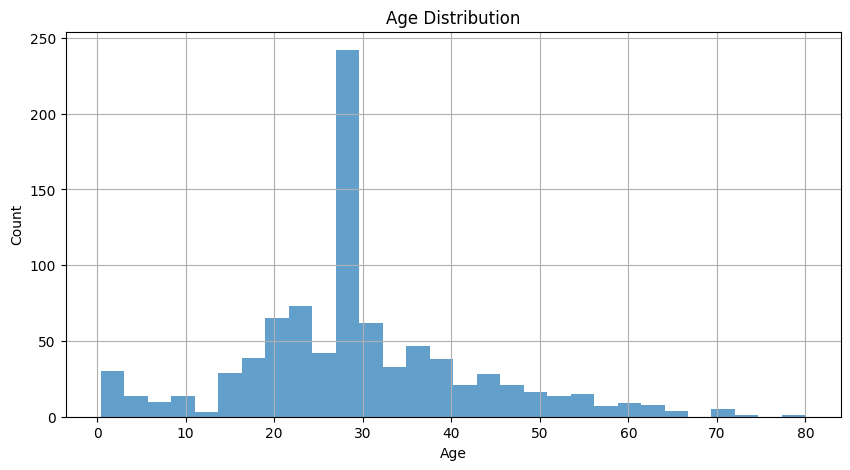

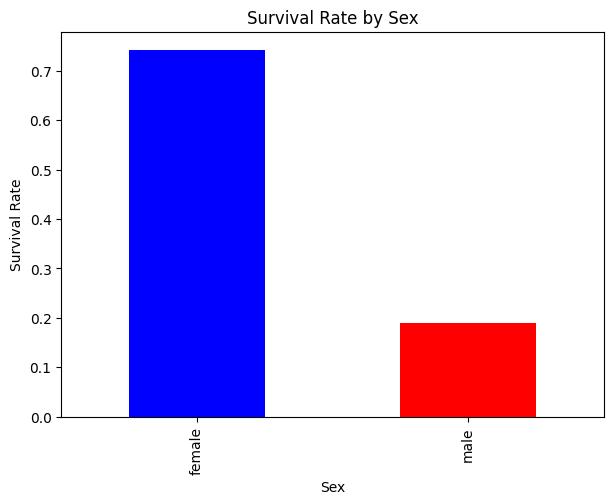

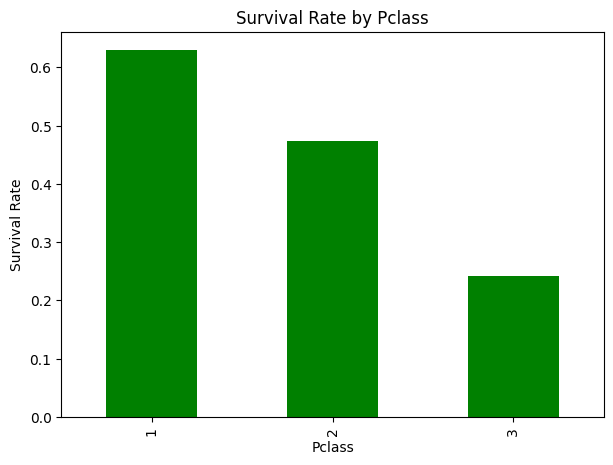

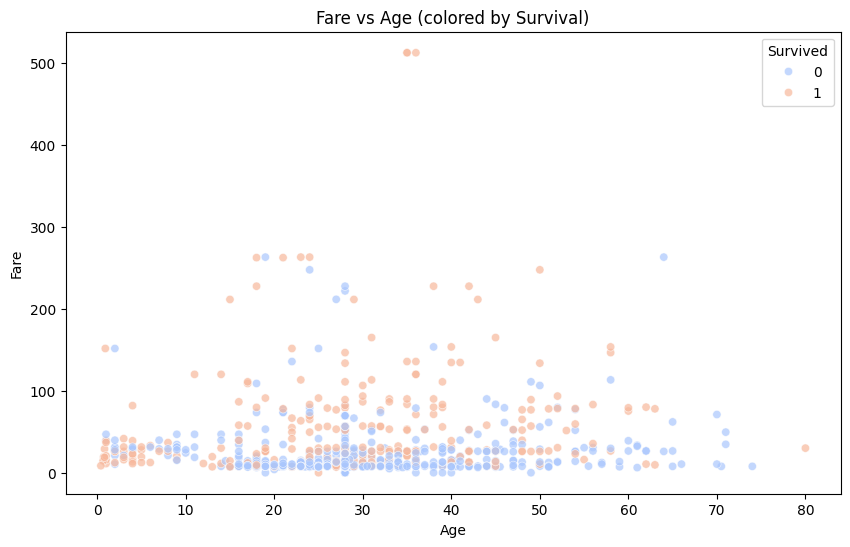

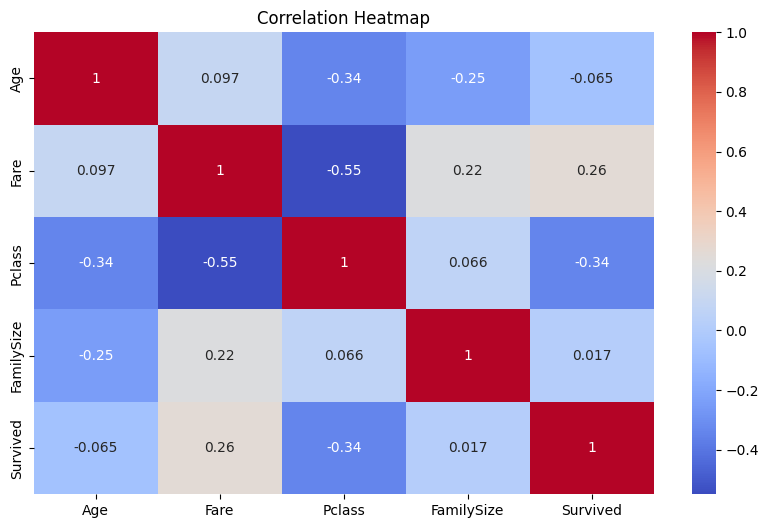

In [ ]:
# 7. Visualization
plt.figure(figsize=(10,5))
train_df['Age'].hist(bins=30, alpha=0.7)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(7,5))
train_df.groupby('Sex')['Survived'].mean().plot(kind='bar', color=['blue','red'])
plt.title("Survival Rate by Sex")
plt.ylabel("Survival Rate")
plt.show()

plt.figure(figsize=(7,5))
train_df.groupby('Pclass')['Survived'].mean().plot(kind='bar', color='green')
plt.title("Survival Rate by Pclass")
plt.ylabel("Survival Rate")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=train_df, palette='coolwarm', alpha=0.7)
plt.title("Fare vs Age (colored by Survival)")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(train_df[['Age','Fare','Pclass','FamilySize','Survived']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
#8. LLM Analysis

#Questions asked:
# 1. Summarize which factors most influenced survival.
# 2. Explain why children might have had higher survival rates than adults.
# 3. Suggest one feature I could create that might improve insights about survival.


from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import pandas as pd
import os


os.environ["OPENAI_API_KEY"] = "n/a"

# --- Create the LLM object ---
llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.6,
    openai_api_key=os.getenv("OPENAI_API_KEY")
)

# --- Example: Titanic summary (replace with your own table) ---
summary_table = pd.DataFrame({
    "Feature": ["Sex", "Pclass", "AgeGroup"],
    "Observation": ["Females had higher survival rate", "Higher class survived more", "Children survived more"]
})
table_markdown = summary_table.to_markdown(index=False)

# --- Define the prompt ---
prompt = PromptTemplate(
    input_variables=["table"],
    template="""
You are an expert data analyst. Analyze the Titanic passenger summary table below.

{table}

Answer the following:
1. Which factors most influenced survival?
2. Explain why children might have higher survival rates than adults.
3. Suggest one new feature or visualization that could improve understanding of survival trends.

Provide your response in clear bullet points under headers.
"""
)

# --- Run the LLMChain ---
chain = LLMChain(llm=llm, prompt=prompt)
response = chain.run(table=table_markdown)

print(response)




Factors Influencing Survival:
- Sex: Females had a higher survival rate compared to males.
- Pclass: Passengers in higher classes had a higher survival rate.
- AgeGroup: Children had a higher survival rate compared to adults.

Reasons for Children's Higher Survival Rates:
- Children may have been given priority during evacuation due to their vulnerability.
- Adults may have sacrificed their spots on lifeboats for children.

Suggested New Feature or Visualization:
- Survival rate by cabin location: This could help determine if proximity to lifeboats or other factors related to cabin location influenced survival rates.
